In [1]:
import nibabel as nib 
! pip install nibabel --user
import os
import glob
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
#import cv2
#! pip install cv2 --user
import time
from datetime import datetime
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import pandas as pd
import os
from skimage.io import imread
from skimage.color import gray2rgb
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision as tv
from torch.utils.data import (
    Dataset,
    DataLoader,
)
import matplotlib.pyplot as plt
from torch.utils import data as DT
from skimage.transform import radon , iradon
%matplotlib inline
!pip install livelossplot --quiet
from livelossplot import PlotLosses

In [586]:
def pad(img_,size_):
    dif=size_-img_.shape[0]
    if dif%2==0:
        img_=np.pad(img_,((dif//2,dif//2),(0,0),(0,0)),'edge')
    else:
        img_=np.pad(img_,(((dif-1)//2,(dif+1)//2),(0,0),(0,0)),'edge')
    dif=size_-img_.shape[1]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(dif//2,dif//2),(0,0)),'edge')
    else:
        img_=np.pad(img_,((0,0),((dif-1)//2,(dif+1)//2),(0,0)),'edge')
    dif=size_-img_.shape[2]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(0,0),(dif//2,dif//2)),'edge')
    else:
        img_=np.pad(img_,((0,0),(0,0),((dif-1)//2,(dif+1)//2)),'edge')
    return img_

In [1034]:
path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'

files = [f for f in glob.glob(path + "**/*_ct_gtvt.nii.gz", recursive=True)]
labels_lenght=list()
image_list=list()
label_list=list()

for idx,f in enumerate(files):
    SEG_img = nib.load(f)
    SEG_data = SEG_img.get_fdata()
    if SEG_data.shape!=(64,64,64):
        SEG_data=pad(SEG_data,64)
    label_list.append(SEG_data)
    path=f[:-15]+'_pt.nii.gz'
    im=nib.load(path)
    PET_data=im.get_fdata()
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    image_list.append(PET_data)
    #print(idx)


In [1035]:
len(image_list) # number of patients

200

In [1036]:
print (image_list[0].shape)

(64, 64, 64)


In [1037]:
size = 16 # patch size
stride = 16 # patch stride

all_labels=list()
for seg_img in label_list:
    patches = torch.from_numpy(seg_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size)
    labels_=torch.sum(reshaped_patches , dim=(1,2,3)).bool().int().numpy()
    all_labels.append(labels_)
all_labels=np.asarray(all_labels).reshape(-1)

In [1038]:
all_labels[:64] # labels of one patient

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1039]:
all_PET_patches=list()
for PET_img in image_list:
    patches = torch.from_numpy(PET_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_PET_patches.append(reshaped_patches)
all_PET_patches=np.asarray(all_PET_patches).reshape(-1,size,size,size)

In [1040]:
print (all_PET_patches.shape) #number of patches * pactch dim1 * patch dim2 * patch dim3
patch_mean=np.mean(all_PET_patches , axis=0)
patch_std=np.std(all_PET_patches , axis=0)

(12800, 16, 16, 16)


In [1041]:
class HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=all_PET_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [1042]:
split_threshold=10000  # to split test and train set

print ('target train 0/1: {}/{}'.format(
    len(np.where(all_labels[:split_threshold] == 0)[0]), len(np.where(all_labels[:split_threshold] == 1)[0])))

class_sample_count = np.array(
    [len(np.where(all_labels[:split_threshold] == t)[0]) for t in np.unique(all_labels[:split_threshold])])
weight = ([2. ,1.]) / class_sample_count
samples_weight = np.array([weight[t] for t in all_labels[:split_threshold]])
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
"""
target = torch.from_numpy(all_labels[:70000]).int()
data=torch.from_numpy(all_PET_patches[:70000])
train_set = torch.utils.data.TensorDataset(data, target)
target = torch.from_numpy(all_labels[70000:]).int()
data=torch.from_numpy(all_PET_patches[70000:])
test_set = torch.utils.data.TensorDataset(data, target)


"""
# Load Data

idx = list(range(len(all_labels)))

dataset = HN_Dataset( transform=tv.transforms.ToTensor())
train_set = DT.Subset(dataset, idx[:split_threshold])
test_set = DT.Subset(dataset, idx[split_threshold:])

#train_set, test_set = torch.utils.data.random_split(dataset, [10000, 2800])

train_set.transform= tv.transforms.Compose([#tv.transforms.RandomHorizontalFlip(),
                                            #tv.transforms.RandomVerticalFlip(),
                                            tv.transforms.ToTensor()
                                            #tv.transforms.Normalize(patch_mean, patch_std)
                                           ])

#tv.transforms.RandomRotation(180),

#train_loader = DataLoader(train_set, batch_size=batch_size, sampler= sampler)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for i, (data, target) in enumerate(train_loader):
    print ("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))
    #print ((data[1].shape))


target train 0/1: 9305/695
batch index 0, 0/1: 58/6
batch index 1, 0/1: 59/5
batch index 2, 0/1: 60/4
batch index 3, 0/1: 58/6
batch index 4, 0/1: 57/7
batch index 5, 0/1: 59/5
batch index 6, 0/1: 54/10
batch index 7, 0/1: 61/3
batch index 8, 0/1: 62/2
batch index 9, 0/1: 59/5
batch index 10, 0/1: 57/7
batch index 11, 0/1: 54/10
batch index 12, 0/1: 58/6
batch index 13, 0/1: 58/6
batch index 14, 0/1: 59/5
batch index 15, 0/1: 60/4
batch index 16, 0/1: 61/3
batch index 17, 0/1: 64/0
batch index 18, 0/1: 60/4
batch index 19, 0/1: 61/3
batch index 20, 0/1: 59/5
batch index 21, 0/1: 60/4
batch index 22, 0/1: 62/2
batch index 23, 0/1: 58/6
batch index 24, 0/1: 59/5
batch index 25, 0/1: 57/7
batch index 26, 0/1: 59/5
batch index 27, 0/1: 59/5
batch index 28, 0/1: 55/9
batch index 29, 0/1: 60/4
batch index 30, 0/1: 63/1
batch index 31, 0/1: 60/4
batch index 32, 0/1: 62/2
batch index 33, 0/1: 62/2
batch index 34, 0/1: 58/6
batch index 35, 0/1: 60/4
batch index 36, 0/1: 62/2
batch index 37, 0/1

In [1043]:

dataIter = iter(train_loader)
imgs, labels = dataIter.next()


print ("labels", labels)


labels tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


In [1044]:

def save_checkpoint(state, filename="my_checkpoint_3D_V2.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [1045]:
class CNN_conv2d(nn.Module):
    def __init__(self, in_channels=16, num_classes=1):
        super(CNN_conv2d, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=16,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv4 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv5 = nn.Conv2d(
            in_channels=4,
            out_channels=4,
            kernel_size=(3 ,3),
            stride=(1, 1),
            padding=(1, 1),
        )
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.fc1 = nn.Linear(16 * 3 * 3, num_classes)
        self.fc2 = nn.Linear(8, num_classes)
        
        self.sig=nn.Sigmoid()
        
        self.BatchNorm64=nn.BatchNorm2d(64)
        self.BatchNorm32=nn.BatchNorm2d(32)
        self.BatchNorm8=nn.BatchNorm2d(8)
        self.BatchNorm128=nn.BatchNorm2d(128)
        self.BatchNorm16=nn.BatchNorm2d(16)
        self.layernorm1=nn.LayerNorm((64, 16, 16))
        self.layernorm2=nn.LayerNorm((32, 8, 8))
        self.layernorm3=nn.LayerNorm((16, 4, 4))
        
        self.initialize_weights()

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        #x= self.layernorm1(x)
        x = self.BatchNorm32(x)
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.BatchNorm16(x)
        #x= self.layernorm2(x)
        x = self.pool(x)
        #x = F.leaky_relu(self.conv3(x))
        #x = self.BatchNorm8(x)
        #x= self.layernorm3(x)
        #x = self.pool(x)
        #x = F.relu(self.conv4(x))
        #x = self.BatchNorm8(x)
        #x = self.pool(x)
        #x = F.relu(self.conv5(x))
        #x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        #x = self.fc2(x)
        x=self.sig(x)
        return x

    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [1046]:
class CNN_conv3d(nn.Module):
    def __init__(self, in_channels=16, num_classes=1):
        super(CNN_conv3d, self).__init__()

        self.conv1 = nn.Conv3d(1, 16, 5, stride=1)
        self.conv2 = nn.Conv3d(16, 16, 3, stride=1)

        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 2 * 2 * 2, num_classes)
        self.sig=nn.Sigmoid()
        self.BatchNorm16=nn.BatchNorm3d(16)

        self.initialize_weights()

        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.BatchNorm16(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.BatchNorm16(x)
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x=self.sig(x)
        return x

    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.xavier_normal_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [1047]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
#in_channel = 32
#num_classes = 2
num_epochs = 50
learning_rate = 1e-3
batch_size = 64

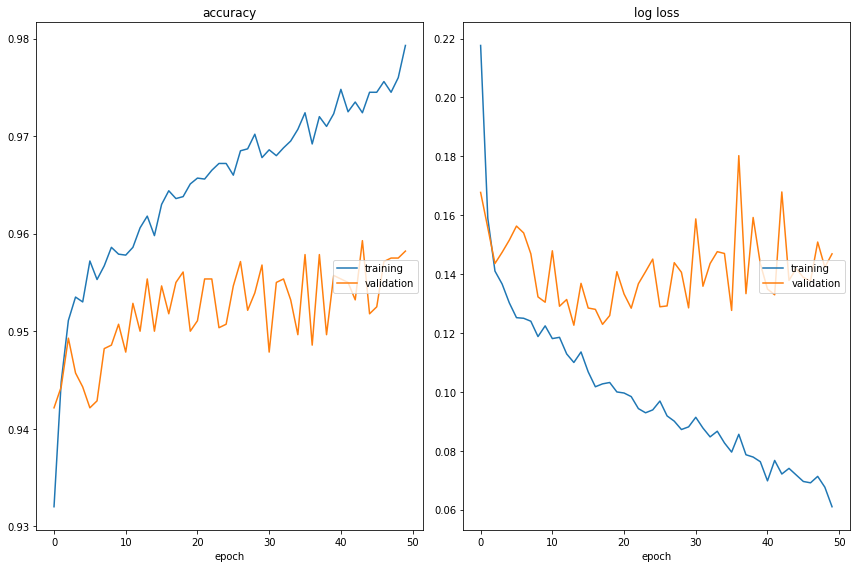

accuracy
	training         	 (min:    0.932, max:    0.979, cur:    0.979)
	validation       	 (min:    0.942, max:    0.959, cur:    0.958)
log loss
	training         	 (min:    0.061, max:    0.218, cur:    0.061)
	validation       	 (min:    0.123, max:    0.180, cur:    0.147)


In [1048]:

# Initialize network
model = CNN_conv2d().to(device)
#model = model.float()
liveloss = PlotLosses()
# Loss and optimizer
criterion = nn.BCELoss()
#criterion=nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False

dataloaders = {
    "train": train_loader,
    "validation": test_loader
}

# Train Network
for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'validation']:

        if phase == 'train':
            model.train()
        else:
            model.eval()

            
        running_loss = 0.0
        running_corrects = 0.0
        #now = datetime.now()

        #losses = []
        for inputs, labels in dataloaders[phase]:
            # Get data to cuda if possible
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # forward
            inputs=inputs.float()
            scores = model(inputs)
            labels=labels.float()
            scores=scores.view(-1)

            loss = criterion(scores, labels)
            #losses.append(loss.item())
            #if phase=='validation':
            #    print (loss)
            # backward
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                # gradient descent or adam step
                optimizer.step()
            preds=torch.round(scores)
    
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        #logs[prefix + 'log'] = epoch_loss.item()

        logs[prefix + 'accuracy'] = epoch_acc.item()
        
    liveloss.update(logs)
    liveloss.send()



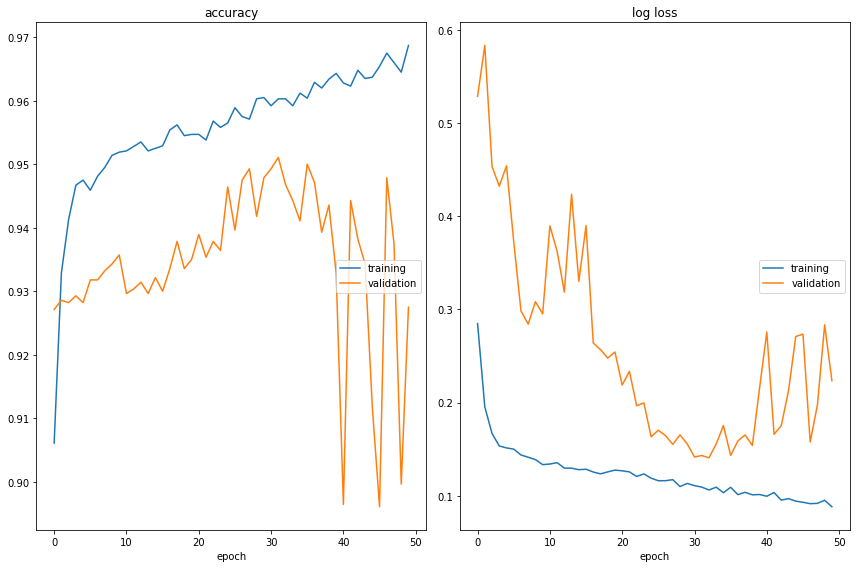

accuracy
	training         	 (min:    0.906, max:    0.969, cur:    0.969)
	validation       	 (min:    0.896, max:    0.951, cur:    0.928)
log loss
	training         	 (min:    0.088, max:    0.285, cur:    0.088)
	validation       	 (min:    0.141, max:    0.583, cur:    0.224)


In [1049]:
# Initialize network
model = CNN_conv3d().to(device)
#model = model.float()
liveloss = PlotLosses()
# Loss and optimizer
criterion = nn.BCELoss()
#criterion=nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False

dataloaders = {
    "train": train_loader,
    "validation": test_loader
}

# Train Network
for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'validation']:

        if phase == 'train':
            model.train()
        else:
            model.eval()

            
        running_loss = 0.0
        running_corrects = 0.0
        #now = datetime.now()

        #losses = []
        for inputs, labels in dataloaders[phase]:
            # Get data to cuda if possible
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # forward
            inputs=inputs.float()
            scores = model(inputs)
            labels=labels.float()
            scores=scores.view(-1)

            loss = criterion(scores, labels)
            #losses.append(loss.item())
            #if phase=='validation':
            #    print (loss)
            # backward
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                # gradient descent or adam step
                optimizer.step()
            preds=torch.round(scores)
    
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        #logs[prefix + 'log'] = epoch_loss.item()

        logs[prefix + 'accuracy'] = epoch_acc.item()
        
    liveloss.update(logs)
    liveloss.send()



In [1063]:
#MAIN
#device = torch.device("cpu")
num_epochs = 12
# Initialize network
model = CNN_conv2d().to(device)
#model = model.float()

# Loss and optimizer
criterion = nn.BCELoss()
#criterion=nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False
print("Current Time =", datetime.now().strftime("%H:%M:%S")) 
# Train Network
for epoch in range(num_epochs):
    now = datetime.now()
    if load_module:
        # load checkpoint
        load_checkpoint(torch.load("my_checkpoint_3D_V2.pth.tar"), model, optimizer)
        load_module=False
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        data=data.float()
        scores = model(data)
        targets=targets.float()
        scores=scores.view(-1)

        loss = criterion(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    if (epoch % 1==0):
        print(f"Cost at epoch {epoch} is {np.sum(losses)/len(losses)}")
        print("Current Time =", now.strftime("%H:%M:%S")) 
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        # save checkpoint
        save_checkpoint(checkpoint)
        


Current Time = 22:30:58
Cost at epoch 0 is 0.2199502102793402
Current Time = 22:30:58
=> Saving checkpoint
Cost at epoch 1 is 0.1550930466526633
Current Time = 22:31:00
=> Saving checkpoint
Cost at epoch 2 is 0.14706125297838715
Current Time = 22:31:03
=> Saving checkpoint
Cost at epoch 3 is 0.13914583580698936
Current Time = 22:31:06
=> Saving checkpoint
Cost at epoch 4 is 0.13190493701844458
Current Time = 22:31:09
=> Saving checkpoint
Cost at epoch 5 is 0.127201640681856
Current Time = 22:31:12
=> Saving checkpoint
Cost at epoch 6 is 0.12202620143248777
Current Time = 22:31:15
=> Saving checkpoint
Cost at epoch 7 is 0.1198383045803969
Current Time = 22:31:17
=> Saving checkpoint
Cost at epoch 8 is 0.1189747363162838
Current Time = 22:31:20
=> Saving checkpoint
Cost at epoch 9 is 0.11737345942076605
Current Time = 22:31:23
=> Saving checkpoint
Cost at epoch 10 is 0.11225346875655803
Current Time = 22:31:26
=> Saving checkpoint
Cost at epoch 11 is 0.11178775890997261
Current Time = 22

In [1064]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model, test_set):
    #s=nn.Sigmoid()

    true_positives,false_positives,true_negatives,false_negatives=0,0,0,0

    num_correct = 0
    num_samples = 0
    model.eval()
    j=0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x=x.float()
            scores = model(x)
            #scores=s(scores)
            predictions=torch.round(scores).view(-1)

            
            #confusion matrix
            confusion_vector = y.cpu() / predictions.cpu()
            true_positives =true_positives+ torch.sum(confusion_vector == 1).item()
            false_positives =false_positives+ torch.sum(confusion_vector == float('inf')).item()
            true_negatives =true_negatives+ torch.sum(torch.isnan(confusion_vector)).item()
            false_negatives =false_negatives+ torch.sum(confusion_vector == 0).item()
            
            
            if test_set:
                #imshow(x.cpu())
                #print ("labels:       ",(y.cpu()))
                #print ("predictions:  ",(predictions.cpu()))
                
                
                print ("labels:       ",np.ravel(y.cpu().numpy()))
                print ("predictions:  ",np.ravel((predictions.cpu().numpy()).astype(np.int)))
                np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
                print (np.ravel(scores.cpu().numpy()))
                #output=scores
                #test_set=False

            num_correct += (predictions.view(-1) == y).sum()
            num_samples += predictions.size(0)
        
        percision= true_positives/(true_positives+false_positives)
        recall=true_positives/(true_positives+false_negatives)
        F1score= 2*(percision*recall)/(percision+recall)
        print(f"Got {num_correct} / {num_samples} with ratio of {float(num_correct)/float(num_samples)*100:.2f}")
        print ("true_positives",true_positives)
        print ("false_positives",false_positives)
        print ("true_negatives",true_negatives)
        print ("false_negatives",false_negatives)
        print ("F1score",F1score)

        
    model.train()



In [1065]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model ,test_set=False)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=False)

Checking accuracy on Training Set
Got 9656 / 10000 with ratio of 96.56
true_positives 475
false_positives 220
true_negatives 9181
false_negatives 124
F1score 0.7341576506955177
Checking accuracy on Test Set
Got 2675 / 2800 with ratio of 95.54
true_positives 103
false_positives 101
true_negatives 2572
false_negatives 24
F1score 0.622356495468278


In [1066]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=True)

Checking accuracy on Test Set
labels:        [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predictions:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0.001  0.004  0.218  0.006  0.002  0.139  0.100  0.018  0.066  0.115
  0.137  0.073  0.041  0.005  0.004  0.001  0.000  0.118  0.646  0.132
  0.007  0.754  0.999  0.412  0.103  0.873  0.961  0.047  0.037  0.017
  0.008  0.001  0.001  0.002  0.002  0.002  0.000  0.178  0.919  0.043
  0.079  0.677  0.987  0.023  0.017  0.629  0.178  0.010  0.000  0.001
  0.001  0.003  0.001  0.001  0.007  0.034  0.003  0.002  0.007  0.047
  0.004  0.006  0.001  0.014]
labels:        [0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predictions:   [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 

labels:        [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predictions:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0.000  0.369  0.223  0.042  0.004  0.137  0.308  0.033  0.064  0.066
  0.135  0.086  0.040  0.021  0.017  0.003  0.001  0.027  0.123  0.092
  0.022  0.972  0.999  0.039  0.149  0.390  0.974  0.058  0.089  0.076
  0.061  0.010  0.000  0.001  0.003  0.001  0.001  0.029  0.733  0.041
  0.007  0.016  0.094  0.037  0.007  0.012  0.008  0.007  0.001  0.001
  0.003  0.002  0.001  0.011  0.005  0.007  0.002  0.015  0.307  0.108
  0.014  0.002  0.003  0.087]
labels:        [0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predictions:   [0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

predictions:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0.000  0.012  0.037  0.068  0.007  0.108  0.266  0.012  0.023  0.026
  0.015  0.157  0.002  0.004  0.003  0.002  0.001  0.029  0.071  0.064
  0.011  0.091  0.883  0.056  0.031  0.062  0.074  0.252  0.003  0.005
  0.002  0.001  0.000  0.000  0.005  0.001  0.002  0.009  0.012  0.033
  0.005  0.012  0.015  0.012  0.001  0.005  0.004  0.011  0.001  0.001
  0.001  0.001  0.001  0.001  0.004  0.002  0.002  0.003  0.038  0.105
  0.002  0.001  0.001  0.009]
labels:        [0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predictions:   [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0.001  0.009  0.030  0.010  0.016  0.305  0.796  0.084  0.049  0.959
  0.411  0.057  0.005  0.005  0.005

In [1067]:
PEAK=200

def make_noisy_image(image):
    img=np.zeros(image.shape)
    for idx, _2d_img in enumerate(image):  
        
        theta = np.linspace(0., 180., max(_2d_img.shape), endpoint=False)
        sinogram = radon(_2d_img, theta=theta, circle=False)
        sinogram=np.clip(sinogram, 0,None)
        noisy = np.random.poisson(sinogram * PEAK)/PEAK  
        img[idx] = iradon(noisy, theta=theta, circle=False)
    return img

In [1068]:

path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'
#_ct_gtvt.nii.gz
#_pt.nii.gz
files = [f for f in glob.glob(path + "**/*_pt.nii.gz", recursive=True)]
noisy_image_list=list()

for idx,f in enumerate(files):
    
    im=nib.load(f)
    PET_data=im.get_fdata()   
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    PET_data=make_noisy_image(PET_data)   
    noisy_image_list.append(PET_data)


In [1078]:
all_noisy_PET_patches=list()
for PET_img in noisy_image_list:
    patches = torch.from_numpy(PET_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_noisy_PET_patches.append(reshaped_patches)
all_noisy_PET_patches=np.asarray(all_noisy_PET_patches).reshape(-1,size,size,size)

In [1079]:
class noisy_HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=all_noisy_PET_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [1080]:
split_threshold=10000
idx = list(range(len(all_labels)))

noisy_dataset = noisy_HN_Dataset( transform=tv.transforms.ToTensor())
noisy_train_set = DT.Subset(noisy_dataset, idx[:split_threshold])
noisy_test_set = DT.Subset(noisy_dataset, idx[split_threshold:])

#train_set, test_set = torch.utils.data.random_split(dataset, [10000, 2800])

#train_loader = DataLoader(train_set, batch_size=batch_size, sampler= sampler
#noisy_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
noisy_test_loader = DataLoader(noisy_test_set, batch_size=batch_size, shuffle=False)


In [1081]:
print("Checking accuracy on Test Set")
check_accuracy(noisy_test_loader, model, test_set=False)

Checking accuracy on Test Set
Got 2674 / 2800 with ratio of 95.50
true_positives 97
false_positives 107
true_negatives 2577
false_negatives 19
F1score 0.60625
